In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from random import uniform, seed
from math import sqrt
import numpy as np

In [2]:
class Agent:

    def __init__(self, type):
        self.type = type
        self.draw_location()

    def draw_location(self):
        self.location = uniform(0, 1), uniform(0, 1)

    def get_distance(self, other):
        "Computes the euclidean distance between self and other agent."
        a = (self.location[0] - other.location[0])**2
        b = (self.location[1] - other.location[1])**2
        return sqrt(a + b)

    def happy(self,
                agents,                # List of other agents
                num_neighbors=10,      # No. of agents viewed as neighbors
                require_same_type=5):  # How many neighbors must be same type
        """
            True if a sufficient number of nearest neighbors are of the same
            type.
        """

        distances = []

        # Distances is a list of pairs (d, agent), where d is distance from
        # agent to self
        for agent in agents:
            if self != agent:
                distance = self.get_distance(agent)
                distances.append((distance, agent))

        # Sort from smallest to largest, according to distance
        distances.sort()

        # Extract the neighboring agents
        neighbors = [agent for d, agent in distances[:num_neighbors]]

        # Count how many neighbors have the same type as self
        num_same_type = sum(self.type == agent.type for agent in neighbors)
        return num_same_type >= require_same_type

    def update(self, agents):
        "If not happy, then randomly choose new locations until happy."
        while not self.happy(agents):
            self.draw_location()

In [3]:
def plot_distribution(agents, cycle_num):
    "Plot the distribution of agents after cycle_num rounds of the loop."
    x_values_0, y_values_0 = [], []
    x_values_1, y_values_1 = [], []
    # == Obtain locations of each type == #
    for agent in agents:
        x, y = agent.location
        if agent.type == 0:
            x_values_0.append(x)
            y_values_0.append(y)
        else:
            x_values_1.append(x)
            y_values_1.append(y)
    fig, ax = plt.subplots()
    plot_args = {'markersize': 8, 'alpha': 0.8}
    ax.set_facecolor('azure')
    ax.plot(x_values_0, y_values_0,
        'o', markerfacecolor='orange', **plot_args)
    ax.plot(x_values_1, y_values_1,
        'o', markerfacecolor='green', **plot_args)
    ax.set_title(f'Cycle {cycle_num-1}')
    plt.show()

In [4]:
def run_simulation(num_of_type_0=600,
                   num_of_type_1=600,
                   max_iter=100_000,       # Maximum number of iterations
                   set_seed=1234):

    # Set the seed for reproducibility
    seed(set_seed)

    # Create a list of agents of type 0
    agents = [Agent(0) for i in range(num_of_type_0)]
    # Append a list of agents of type 1
    agents.extend(Agent(1) for i in range(num_of_type_1))

    # Initialize a counter
    count = 1

    # Plot the initial distribution
    plot_distribution(agents, count)

    # Loop until no agent wishes to move
    while count < max_iter:
        print('Entering loop ', count)
        count += 1
        no_one_moved = True
        for agent in agents:
            old_location = agent.location
            agent.update(agents)
            if agent.location != old_location:
                no_one_moved = False
        if no_one_moved:
            break

    # Plot final distribution
    plot_distribution(agents, count)

    if count < max_iter:
        print(f'Converged after {count} iterations.')
    else:
        print('Hit iteration bound and terminated.')


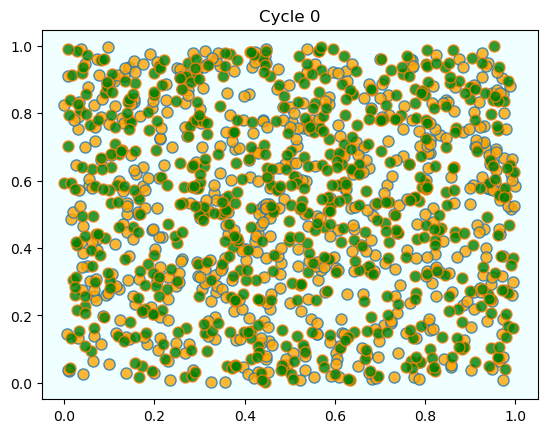

Entering loop  1


Entering loop  2


Entering loop  3


Entering loop  4


Entering loop  5


Entering loop  6


Entering loop  7


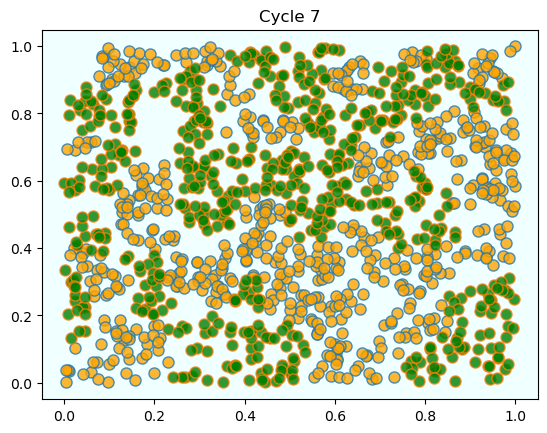

Converged after 8 iterations.


In [5]:
run_simulation()

In [6]:
from numpy.random import uniform, randint

n = 1000                # number of agents (agents = 0, ..., n-1)
k = 10                  # number of agents regarded as neighbors
require_same_type = 5   # want >= require_same_type neighbors of the same type

def initialize_state():
    locations = uniform(size=(n, 2))
    types = randint(0, high=2, size=n)   # label zero or one
    return locations, types


def compute_distances_from_loc(loc, locations):
    """ Compute distance from location loc to all other points. """
    return np.linalg.norm(loc - locations, axis=1)

def get_neighbors(loc, locations):
    " Get all neighbors of a given location. "
    all_distances = compute_distances_from_loc(loc, locations)
    indices = np.argsort(all_distances)   # sort agents by distance to loc
    neighbors = indices[:k]               # keep the k closest ones
    return neighbors

def is_happy(i, locations, types):
    happy = True
    agent_loc = locations[i, :]
    agent_type = types[i]
    neighbors = get_neighbors(agent_loc, locations)
    neighbor_types = types[neighbors]
    if sum(neighbor_types == agent_type) < require_same_type:
        happy = False
    return happy

def count_happy(locations, types):
    " Count the number of happy agents. "
    happy_sum = 0
    for i in range(n):
        happy_sum += is_happy(i, locations, types)
    return happy_sum

def update_agent(i, locations, types):
    " Move agent if unhappy. "
    moved = False
    while not is_happy(i, locations, types):
        moved = True
        locations[i, :] = uniform(), uniform()
    return moved

def plot_distribution(locations, types, title, savepdf=False):
    " Plot the distribution of agents after cycle_num rounds of the loop."
    fig, ax = plt.subplots()
    colors = 'orange', 'green'
    for agent_type, color in zip((0, 1), colors):
        idx = (types == agent_type)
        ax.plot(locations[idx, 0],
                locations[idx, 1],
                'o',
                markersize=8,
                markerfacecolor=color,
                alpha=0.8)
    ax.set_title(title)
    plt.show()

def sim_random_select(max_iter=100_000, flip_prob=0.01, test_freq=10_000):
    """
    Simulate by randomly selecting one household at each update.

    Flip the color of the household with probability `flip_prob`.

    """

    locations, types = initialize_state()
    current_iter = 0

    while current_iter <= max_iter:

        # Choose a random agent and update them
        i = randint(0, n)
        moved = update_agent(i, locations, types)

        if flip_prob > 0:
            # flip agent i's type with probability epsilon
            U = uniform()
            if U < flip_prob:
                current_type = types[i]
                types[i] = 0 if current_type == 1 else 1

        # Every so many updates, plot and test for convergence
        if current_iter % test_freq == 0:
            cycle = current_iter / n
            plot_distribution(locations, types, f'iteration {current_iter}')
            if count_happy(locations, types) == n:
                print(f"Converged at iteration {current_iter}")
                break

        current_iter += 1

    if current_iter > max_iter:
        print(f"Terminating at iteration {current_iter}")

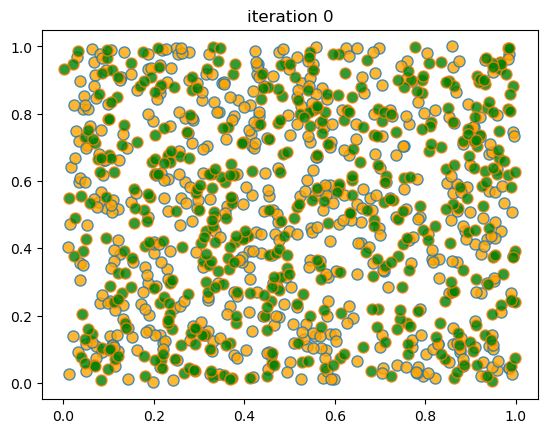

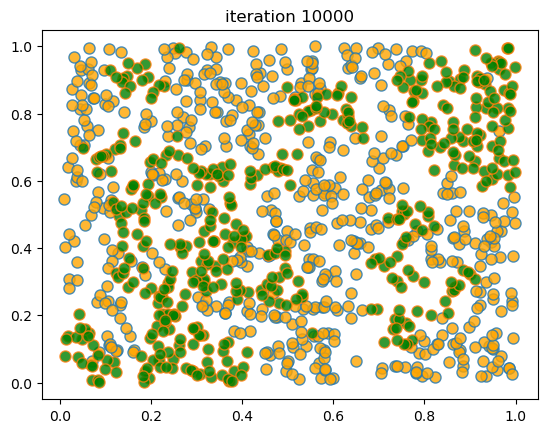

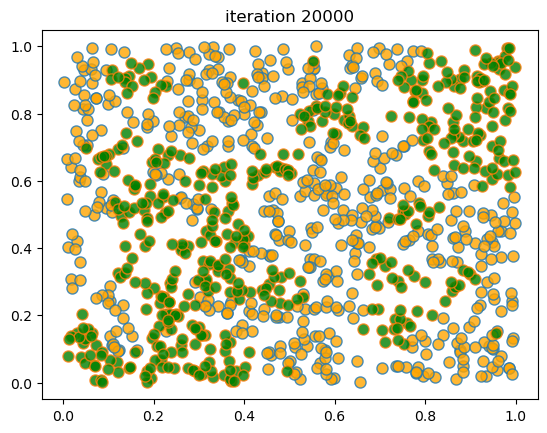

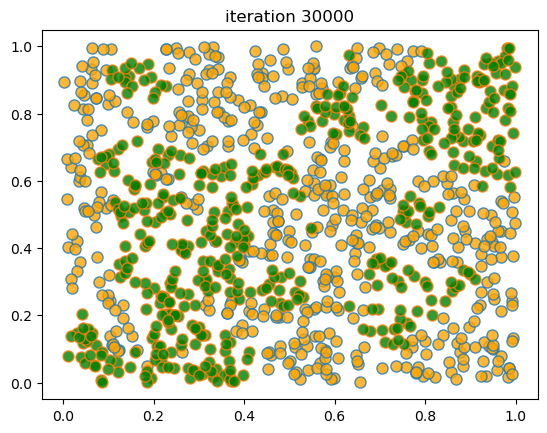

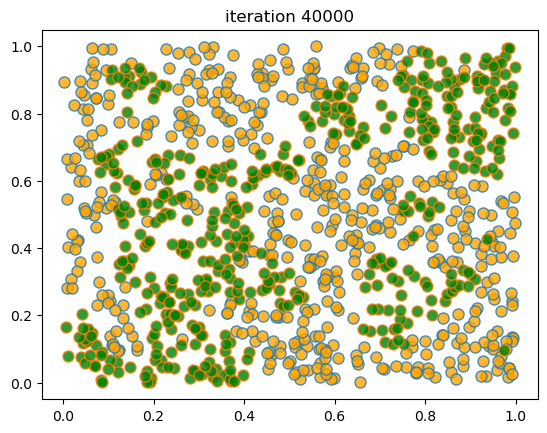

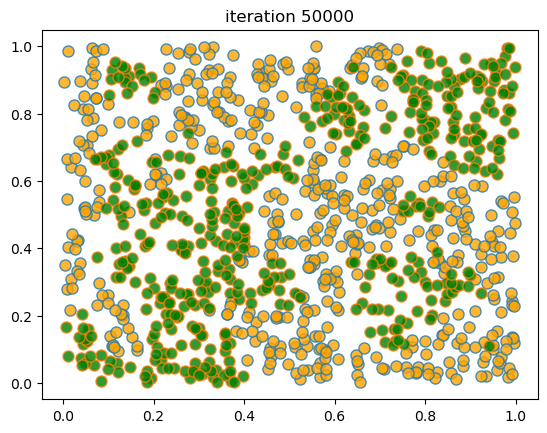

Terminating at iteration 50001


In [7]:
sim_random_select(max_iter=50_000, flip_prob=0.01, test_freq=10_000)